In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functools import reduce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

pd.set_option('display.max_columns', 120)
DATA_DIR = Path('data')
OUT_DIR = Path('processed')
OUT_DIR.mkdir(exist_ok=True)

In [14]:
# Load datasets
climate_files = [
    'Huye_climate_data.csv','Kigali_climate_data.csv','Muhanga_climate_data.csv',
    'Kibungo_climate_data.csv','Musanze_climate_data.csv','Nyagatare_climate_data.csv',
    'Rubavu_climate_data.csv','Rusizi_climate_data.csv'
]

climate_dfs = {}
for f in climate_files:
    loc = f.split('_')[0].lower()
    df = pd.read_csv(DATA_DIR / f, parse_dates=['Date'], na_values=['-999.0', -999.0])
    df.replace(-999.0, np.nan, inplace=True)
    climate_dfs[loc] = df

tomato = pd.read_csv(DATA_DIR / 'Tomato_price.csv', parse_dates=['Date'])
harvest = pd.read_csv(DATA_DIR / 'harvest_dataset.csv', parse_dates=['Date'])

print(f"Loaded {len(climate_dfs)} climate datasets, tomato: {tomato.shape}, harvest: {harvest.shape}")

Loaded 8 climate datasets, tomato: (2814, 6), harvest: (10000, 3)


/tmp/ipykernel_312314/555872016.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_312314/555872016.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Tomato columns: ['Date', 'Unit', 'Minimum', 'Maximum', 'Average', 'Market']
        Date Unit  Minimum  Maximum  Average  Market
0 2013-06-16   Kg       26       32     29.0  Tomato
1 2013-06-17   Kg       20       25     22.5  Tomato
2 2013-06-18   Kg       22       26     24.0  Tomato
3 2013-06-19   Kg       24       28     26.0  Tomato
4 2013-06-20   Kg       22       26     24.0  Tomato
                     Date    Harvest_kg  Price_index
0 2019-04-20 19:32:07.020   8856.116731     2.162283
1 2013-07-19 05:03:54.932  27675.990789     0.592934
2 2013-03-17 16:29:23.671  18517.735088     0.575836
3 2017-04-16 16:15:51.796  26542.417336     1.267037
4 2018-06-15 00:21:06.744  10173.828468     0.881346


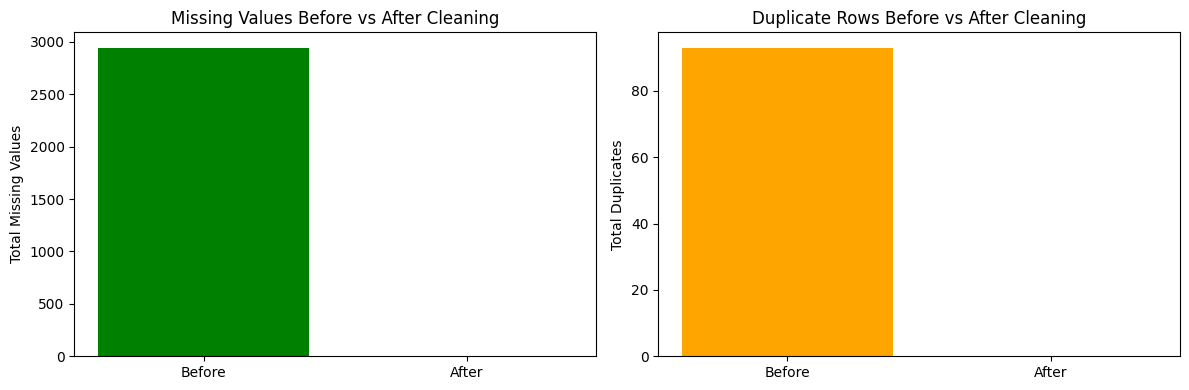

In [15]:
# 1. DATA CLEANING
missing_before = sum(df.isnull().sum().sum() for df in climate_dfs.values()) + tomato.isnull().sum().sum() + harvest.isnull().sum().sum()
duplicates_before = sum(df.duplicated().sum() for df in climate_dfs.values()) + tomato.duplicated().sum() + harvest.duplicated().sum()

# Clean climate data
for loc, df in climate_dfs.items():
    df.drop_duplicates(inplace=True)
    for col in df.select_dtypes(include='number').columns:
        df[col].fillna(df[col].median(), inplace=True)

# Clean tomato and harvest
print('Tomato columns:', tomato.columns.tolist())
tomato.drop_duplicates(inplace=True)
tomato['Average'] = pd.to_numeric(tomato['Average'], errors='coerce')
tomato['Average'].fillna(tomato['Average'].median(), inplace=True)
print(tomato.head())

harvest.drop_duplicates(inplace=True)
harvest['Date'] = pd.to_datetime(harvest['Date']).dt.tz_localize(None)
for col in harvest.select_dtypes(include='number').columns:
    harvest[col].fillna(harvest[col].median(), inplace=True)

missing_after = sum(df.isnull().sum().sum() for df in climate_dfs.values()) + tomato.isnull().sum().sum() + harvest.isnull().sum().sum()
duplicates_after = sum(df.duplicated().sum() for df in climate_dfs.values()) + tomato.duplicated().sum() + harvest.duplicated().sum()
print(harvest.head())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(['Before', 'After'], [missing_before, missing_after], color=['green'])
plt.title('Missing Values Before vs After Cleaning')
plt.ylabel('Total Missing Values')

plt.subplot(1,2,2)
plt.bar(['Before', 'After'], [duplicates_before, duplicates_after], color=['orange', 'green'])
plt.title('Duplicate Rows Before vs After Cleaning')
plt.ylabel('Total Duplicates')
plt.tight_layout()
plt.show()

        Date    Harvest_kg  Price_index
0 2013-01-01  46919.368462     2.150701
1 2013-01-02  23410.933334     1.946153
2 2013-01-03  13505.752157     2.288874
3 2013-01-04  66938.567811     1.757647
4 2013-01-05  38391.830095     1.116661
         Date unit  min_price  max_price  price_avg  market    temp_c  \
0  2013-06-16   Kg         26         32       29.0  Tomato  18.41250   
1  2013-06-17   Kg         20         25       22.5  Tomato  18.13500   
2  2013-06-18   Kg         22         26       24.0  Tomato  17.27875   
3  2013-06-19   Kg         24         28       26.0  Tomato  16.96875   
4  2013-06-20   Kg         22         26       24.0  Tomato  17.16375   
5  2013-06-21   Kg         15         20       17.5  Tomato  17.22125   
6  2013-06-25   Kg         25         30       27.5  Tomato  18.72250   
7  2013-06-26   Kg         20         25       22.5  Tomato  18.84500   
8  2013-06-27   Kg         18         24       21.0  Tomato  18.44625   
9  2013-06-28   Kg         24 

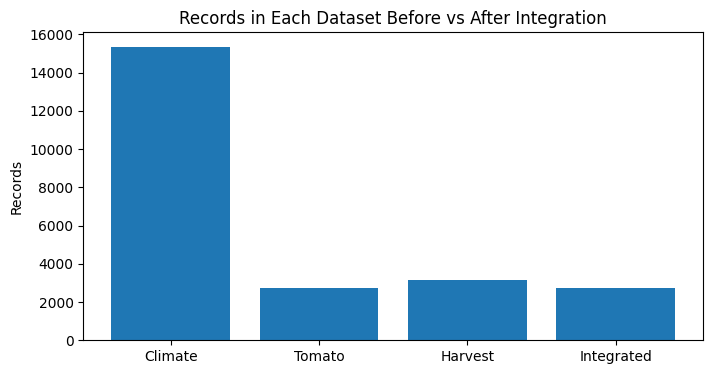

Integrated dataset shape: (2741, 12)


In [16]:
# 2. DATA INTEGRATION
# Rename and aggregate climate data
for loc, df in climate_dfs.items():
    df.rename(columns={'T2M':'temp_c','PRECTOTCORR':'precip_mm','WS2M':'wind_m_s','RH2M':'rh_pct','ALLSKY_SFC_SW_DWN':'sw_down'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    climate_dfs[loc] = df.groupby('Date').agg({'temp_c':'mean','precip_mm':'sum','wind_m_s':'mean','rh_pct':'mean','sw_down':'mean'}).reset_index()

# Merge all climate stations
all_daily = [df.rename(columns=lambda c: f"{loc}_{c}" if c!='Date' else c) for loc, df in climate_dfs.items()]
climate_all = reduce(lambda a,b: a.merge(b,on='Date',how='outer'), all_daily)

temp_cols = [c for c in climate_all.columns if c.endswith('temp_c')]
precip_cols = [c for c in climate_all.columns if c.endswith('precip_mm')]
wind_cols = [c for c in climate_all.columns if c.endswith('wind_m_s')]
rh_cols = [c for c in climate_all.columns if c.endswith('rh_pct')]

climate_avg = pd.DataFrame({
    'Date': climate_all['Date'],
    'temp_c': climate_all[temp_cols].mean(axis=1),
    'precip_mm': climate_all[precip_cols].sum(axis=1),
    'wind_m_s': climate_all[wind_cols].mean(axis=1),
    'rh_pct': climate_all[rh_cols].mean(axis=1)
}).drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Clean and merge tomato data
tomato.rename(columns={'Date':'Date','Average':'price_avg','Market':'market','Unit':'unit','Minimum':'min_price','Maximum':'max_price'}, inplace=True)
tomato['Date'] = pd.to_datetime(tomato['Date']).dt.normalize()

# Merge harvest data
harvest['Date'] = pd.to_datetime(harvest['Date']).dt.normalize()
harvest_daily = harvest.groupby('Date').agg({'Harvest_kg':'sum','Price_index':'mean'}).reset_index()
print(harvest_daily.head())
# Final integration
integrated_df = tomato.merge(climate_avg, on='Date', how='left').merge(harvest_daily, on='Date', how='left')
print(integrated_df.head(50))
integrated_df[['Harvest_kg','Price_index']] = integrated_df[['Harvest_kg','Price_index']].ffill().bfill()

plt.figure(figsize=(8,4))
plt.bar(['Climate', 'Tomato', 'Harvest', 'Integrated'], [len(climate_avg), len(tomato), len(harvest_daily), len(integrated_df)])
plt.title('Records in Each Dataset Before vs After Integration')
plt.ylabel('Records')
plt.show()

print(f"Integrated dataset shape: {integrated_df.shape}")

        Date  price_avg    temp_c  precip_mm  wind_m_s    rh_pct  \
0 2013-06-16       29.0  18.41250       0.11   1.23875  74.01500   
1 2013-06-17       22.5  18.13500       0.03   1.25500  74.33000   
2 2013-06-18       24.0  17.27875       0.00   1.35125  77.99125   
3 2013-06-19       26.0  16.96875       0.01   1.23875  74.26125   
4 2013-06-20       24.0  17.16375       0.01   1.31625  74.33625   

      Harvest_kg  Price_index  
0   13441.763497     0.791713  
1   13441.763497     0.791713  
2   97188.778915     1.531655  
3   27221.515796     1.499719  
4  121402.520954     1.286835  


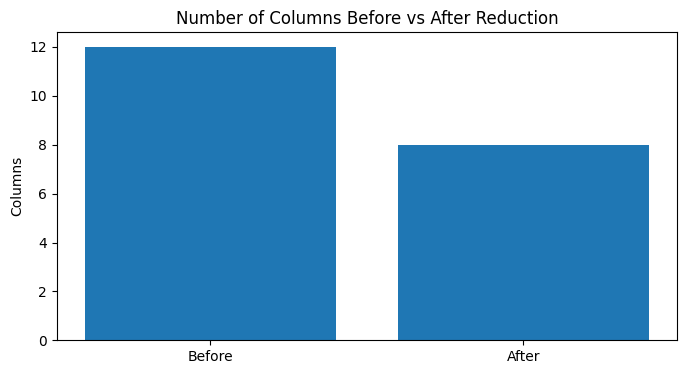

Reduced from 12 to 8 columns


In [17]:
# 3. DATA REDUCTION
reduce_cols = ['Date', 'price_avg', 'temp_c', 'precip_mm', 'wind_m_s', 'rh_pct', 'Harvest_kg', 'Price_index']
reduced_df = integrated_df[reduce_cols].copy()
print(reduced_df.head())

plt.figure(figsize=(8,4))
plt.bar(['Before', 'After'], [integrated_df.shape[1], reduced_df.shape[1]])
plt.title('Number of Columns Before vs After Reduction')
plt.ylabel('Columns')
plt.show()

print(f"Reduced from {integrated_df.shape[1]} to {reduced_df.shape[1]} columns")

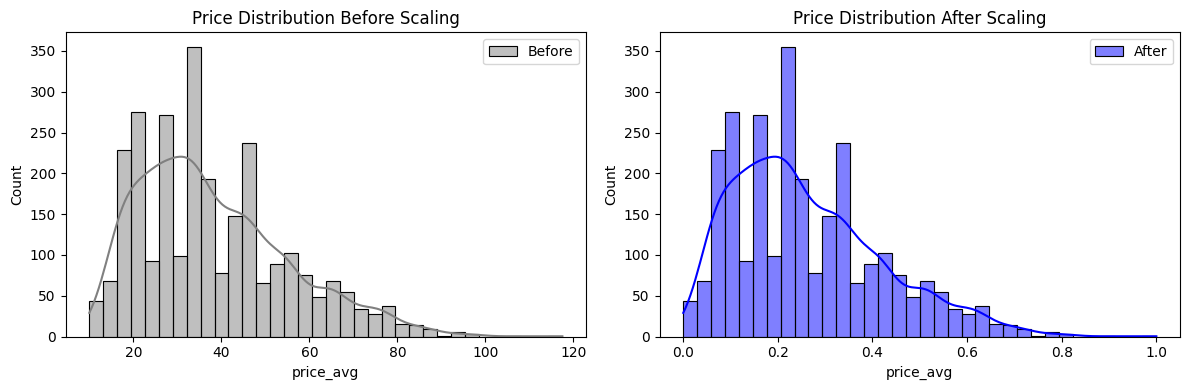

In [18]:
# 4. DATA TRANSFORMATION
scaler = MinMaxScaler()
numeric_cols = ['price_avg', 'temp_c', 'precip_mm', 'wind_m_s', 'rh_pct', 'Harvest_kg', 'Price_index']
reduced_df[numeric_cols] = scaler.fit_transform(reduced_df[numeric_cols])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(integrated_df['price_avg'].dropna(), kde=True, color='gray', label='Before')
plt.legend()
plt.title('Price Distribution Before Scaling')

plt.subplot(1,2,2)
sns.histplot(reduced_df['price_avg'], kde=True, color='blue', label='After')
plt.legend()
plt.title('Price Distribution After Scaling')
plt.tight_layout()
plt.show()

/tmp/ipykernel_312314/3938483911.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reduced_df['temp_category'], palette='coolwarm')
/tmp/ipykernel_312314/3938483911.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reduced_df['precip_category'], palette='Blues')


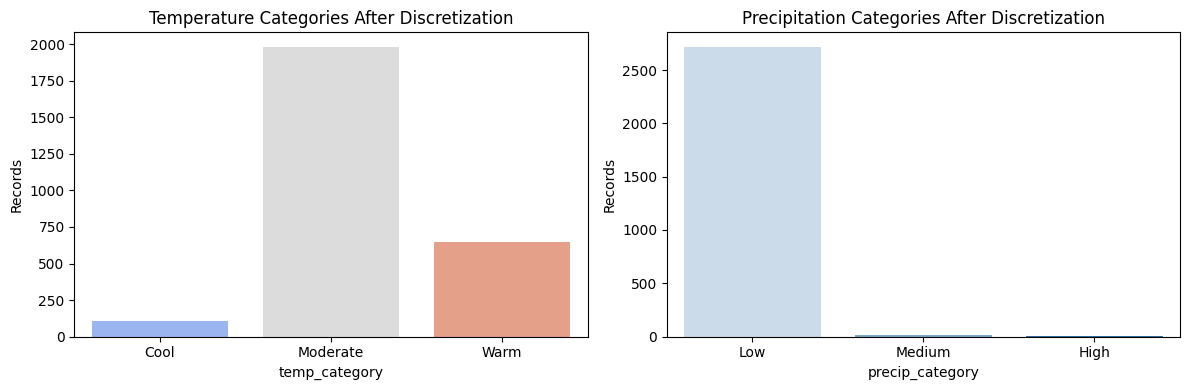

In [19]:
# 5. DATA DISCRETIZATION
reduced_df['temp_category'] = pd.cut(reduced_df['temp_c'], bins=3, labels=['Cool', 'Moderate', 'Warm'])
reduced_df['precip_category'] = pd.cut(reduced_df['precip_mm'], bins=3, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x=reduced_df['temp_category'], palette='coolwarm')
plt.title('Temperature Categories After Discretization')
plt.ylabel('Records')

plt.subplot(1,2,2)
sns.countplot(x=reduced_df['precip_category'], palette='Blues')
plt.title('Precipitation Categories After Discretization')
plt.ylabel('Records')
plt.tight_layout()
plt.show()

          Date  price_avg    temp_c  precip_mm  wind_m_s    rh_pct  \
0   2013-06-16   0.176744  0.507131   0.000159  0.296741  0.578778   
1   2013-06-17   0.116279  0.471151   0.000043  0.304174  0.586001   
2   2013-06-18   0.130233  0.360130   0.000000  0.348199  0.669953   
3   2013-06-19   0.148837  0.319935   0.000014  0.296741  0.584425   
4   2013-06-20   0.130233  0.345219   0.000014  0.332190  0.586145   
..         ...        ...       ...        ...       ...       ...   
195 2014-02-18   0.209302  0.745543   0.000794  0.197827  0.452636   
196 2014-02-20   0.241860  0.586386   0.091135  0.197827  0.722692   
197 2014-02-21   0.200000  0.634522   0.006383  0.323613  0.629339   
198 2014-02-23   0.162791  0.778930   0.027740  0.214408  0.578807   
199 2014-02-24   0.223256  0.513614   0.010542  0.178388  0.844450   

     Harvest_kg  Price_index temp_category precip_category    source  
0      0.063594     0.144591      Moderate             Low  Original  
1      0.063594  

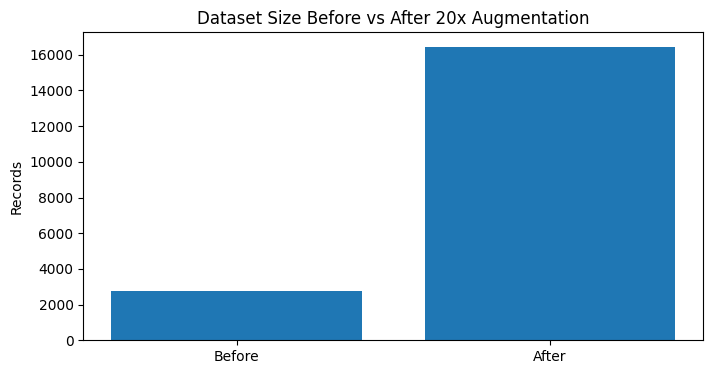

Final dataset shape: (16441, 11)
Original records: 2741
Synthetic records: 13700


In [27]:
# 6. DATA AUGMENTATION

reduced_df['source'] = 'Original'

augmented_batches = []   # to store each augmentation batch

for i in range(50):  # augment 20 times
    augmented = reduced_df.sample(frac=0.1, random_state=42 + i).copy()
    
    # add noise
    augmented[numeric_cols] += np.random.normal(
        0, 0.05, size=(augmented.shape[0], len(numeric_cols))
    )
    
    augmented['source'] = f'Synthetic_{i+1}'
    augmented_batches.append(augmented)

# combine everything
augmented_df = pd.concat([reduced_df] + augmented_batches, ignore_index=True)

print(augmented_df.head(200))

# plot dataset growth
plt.figure(figsize=(8,4))
plt.bar(['Before', 'After'], [reduced_df.shape[0], augmented_df.shape[0]])
plt.title('Dataset Size Before vs After 20x Augmentation')
plt.ylabel('Records')
plt.show()

# summary
print(f"Final dataset shape: {augmented_df.shape}")
print(f"Original records: {(augmented_df['source'] == 'Original').sum()}")
print(f"Synthetic records: {(augmented_df['source'] != 'Original').sum()}")

In [28]:
# Save processed data
duplicate_count = augmented_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")
augmented_df.to_csv(OUT_DIR / 'processed_farmer_data.csv', index=False)

print(f"Processed data saved to {OUT_DIR / 'processed_farmer_data.csv'}")
print("\nFinal dataset summary:")
print(augmented_df.info())
print("\nFirst 5 rows:")
print(augmented_df.head())


Number of duplicate rows: 0
Processed data saved to processed/processed_farmer_data.csv

Final dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16441 entries, 0 to 16440
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             16441 non-null  datetime64[ns]
 1   price_avg        16441 non-null  float64       
 2   temp_c           16441 non-null  float64       
 3   precip_mm        16441 non-null  float64       
 4   wind_m_s         16441 non-null  float64       
 5   rh_pct           16441 non-null  float64       
 6   Harvest_kg       16441 non-null  float64       
 7   Price_index      16441 non-null  float64       
 8   temp_category    16441 non-null  category      
 9   precip_category  16441 non-null  category      
 10  source           16441 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(7), object(1)
memory usage: 1.2+ MB
None
